In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# Distances & Similarities

Distances and similarities are fundamental concepts used to quantify how alike or different objects are, whether they are numbers, vectors, images, texts, or more abstract entities. In mathematics, computer science, and data analysis, distance measures capture dissimilarity by assigning a numerical value that grows larger as objects diverge, while similarity measures do the opposite, reflecting closeness or resemblance with higher values. These notions are central to tasks like clustering, classification, recommendation systems, and information retrieval, since they provide the basis for comparing data points and identifying meaningful patterns.

Most of the distances (if not all of them) are already implemented in specialized libraries. In real life application rely on those implementations due to it being well optimized, unless you have a highly special usecase. List of implementation resources: 
- [Scipy Distance computations](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)
- [Scipy Statistical distances](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-distances)
- [Distances Library](https://github.com/LucaCappelletti94/dictances)

# Distances in Euclidian Space

These distances apply when data poins are represented as vectors in $\mathbb{R}^n$. They measure geometric relationships between points.

In [2]:
# Load Iris
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

# Standardize features (important for distances)
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

print("Iris shape:", X_iris_scaled.shape)
print("Classes:", set(y_iris))

Iris shape: (150, 4)
Classes: {np.int64(0), np.int64(1), np.int64(2)}


In [3]:
X_iris[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

## Minkowski Distance
The Minkowski distance generalizes several norms.

$$D_p(x,y) = \left( \sum_{i=1}^n |x_i - y_i|^p \right)^{\frac{1}{p}}$$

- $p=2$ → Euclidean distance
- $p=1$ → Manhattan distance

## Mahalanobis Distance

Mahalanobis distance accounts for correlations in the data, thus measuring 

$$D_M(x,y) = \sqrt{ (x-y)^T \, \Sigma^{-1} \, (x-y) }$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from matplotlib.patches import Ellipse

@interact(
    loc_x=widgets.FloatSlider(min=-5, max=5, step=0.1, value=3),
    loc_y=widgets.FloatSlider(min=-5, max=5, step=0.1, value=2),
    cov_x=widgets.FloatSlider(min=1, max=5, step=0.1, value=3),
    cov_y=widgets.FloatSlider(min=1, max=5, step=0.1, value=2),
)
def maha_demosntration_plot(loc_x, loc_y, cov_x, cov_y):
    fix, axs = plt.subplots(1, 2, figsize=(11,6))
    
    ax = axs[0]
    # Mean and covariance
    mean = np.array([0, 0])
    cov = np.array([[cov_x, 1], [1, cov_y]])
    cov_inv = np.linalg.inv(cov)
    
    # Point to measure distance from mean
    x = np.array([loc_x, loc_y])
    
    # Euclidean distance
    euclidean_d = np.linalg.norm(x - mean)
    
    # Mahalanobis distance
    mahal_d = distance.mahalanobis(x, mean, cov_inv)
    
    # Covariance ellipse (1 std dev)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    theta = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    ellipse = Ellipse(xy=mean, width=2*np.sqrt(eigvals[0]), height=2*np.sqrt(eigvals[1]),
                      angle=theta, edgecolor='red', fc='None', lw=2, ls='--', label="Covariance ellipse")
    
    # Plot
    ax.scatter(*mean, c='black', marker='x', s=100, label="Mean")
    ax.scatter(*x, c='blue', s=100, label="Point")
    
    # Euclidean distance (straight line)
    ax.plot([mean[0], x[0]], [mean[1], x[1]], 'g--', label=f"Euclidean = {euclidean_d:.2f}")
    
    # Mahalanobis "unit circle" contour
    # Scale ellipse by Mahalanobis distance to show where x lies
    ellipse_scaled = Ellipse(xy=mean,
                             width=2*mahal_d*np.sqrt(eigvals[0]),
                             height=2*mahal_d*np.sqrt(eigvals[1]),
                             angle=theta,
                             edgecolor='blue', fc='None', lw=2, ls=':', label=f"Mahalanobis = {mahal_d:.2f}")
    ax.add_patch(ellipse_scaled)
    
    ax.add_patch(ellipse)
    ax.legend()
    ax.set_title("Euclidean vs Mahalanobis Distance")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')

    ax = axs[1]
    # Grid for visualization
    xv, yv = np.meshgrid(np.linspace(-5, 5, 200), np.linspace(-5, 5, 200))
    grid_points = np.column_stack([xv.ravel(), yv.ravel()])
    
    # Mahalanobis distance for each grid point
    distances = [distance.mahalanobis(p, mean, cov_inv) for p in grid_points]
    distances = np.array(distances).reshape(xv.shape)
    
    # Covariance ellipse (1 std dev)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    theta = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    ellipse = Ellipse(xy=mean, width=2*np.sqrt(eigvals[0]), height=2*np.sqrt(eigvals[1]),
                      angle=theta, edgecolor='red', fc='None', lw=2, ls='--', label="Covariance ellipse")
    
    # Plot heatmap
    contour = ax.contourf(xv, yv, distances, levels=30, cmap="viridis")
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label("Mahalanobis distance")
    
    # Overlay ellipse and mean
    ax.add_patch(ellipse)
    ax.scatter(*mean, c="black", marker="x", s=100, label="Mean")
    
    ax.set_title("Mahalanobis Distance Heatmap")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect("equal")
    ax.legend()
    fig.tight_layout()
    fig.set_size_inches(16, 16)

## Cosine Distance

Cosine distance measures angular difference between vectors, ignoring magnitude.

$$D_{\cos}(x,y) = 1 - \frac{x \cdot y}{\|x\|\|y\|}$$

# Distances Between Objects

When working with sets or strings (or any object in general), different definitions of distance are more appropriate.

[MovieLens](https://grouplens.org/datasets/movielens/)

In [4]:
# Load MovieLens 100k (userId, movieId, rating, timestamp)
ml = pd.read_csv("https://raw.githubusercontent.com/ficstamas/data-mining/ef35c46e65be57364023dd0eca3e6cebee97ec65/data/movielens/ratings.csv")
# movies.csv -> movieId, title, genres
# links.csv -> movieId, imdbId, tmdbId
# tags.csv -> userId, movieId, tag, timestamp

# Build "set of movies watched" for each user
user_movies = ml.groupby("userId")["movieId"].apply(set)

A = user_movies.loc[1]
B = user_movies.loc[2]
user_movies

userId
1      {1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, ...
2      {115713, 122882, 48516, 91529, 80906, 91658, 1...
3      {5764, 647, 3210, 527, 914, 1302, 31, 2080, 59...
4      {1025, 3079, 3591, 2571, 3083, 21, 1046, 2583,...
5      {1, 515, 261, 265, 266, 527, 531, 21, 150, 534...
                             ...                        
606    {1, 8195, 6148, 7, 11, 69644, 4109, 15, 17, 18...
607    {1, 517, 2053, 2054, 1544, 3081, 11, 1036, 257...
608    {1, 2, 3, 2052, 2054, 4104, 4105, 10, 2060, 61...
609    {1, 137, 10, 650, 1161, 786, 150, 288, 161, 10...
610    {1, 122882, 122884, 6, 122886, 81932, 73741, 1...
Name: movieId, Length: 610, dtype: object

## Jaccard Similarity

For sets $A$ and $B$, the Jaccard similarity measures overlap:

$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

## Edit (Levenshtein) Distance

Measures how many operations (insertions, deletions, substitutions) are needed to transform one string into another.

$$
D_L(i,j) = 
\begin{cases} 
    \max(i,j) & \text{if } \min(i,j) = 0, \\[6pt]
    \min \begin{cases} 
        D_L(i-1, j) + 1, \\ 
        D_L(i, j-1) + 1, \\ 
        D_L(i-1, j-1) + \mathbf{1}_{[a_i \neq b_j]}
    \end{cases} & \text{otherwise,}
\end{cases}
$$
where $a$ and $b$ are the input strings, $\mathbf{1}_{[a_i \neq b_j]}$ is an indicator function that is equal to 1 if $a_i \neq b_j$ 0 otherwise.

# Distances Between Distributions

When comparing probability distributions, distances capture how different two distributions are.

We’ll illustrate using two Gaussian distributions $p = \mathcal{N}(0,1)$ and $q = \mathcal{N}(1,1)$.

In [5]:
def generate_dummy_points(p_mu=0, p_std=1, q_mu=1, q_std=1):
    # Two Gaussian distributions
    p = norm(p_mu, p_std)
    q = norm(q_mu, q_std)
    
    x = np.linspace(-4, 5, 1000)
    p_pdf = p.pdf(x)
    q_pdf = q.pdf(x)
    return p_pdf, q_pdf, x

In [6]:
@interact(
    p_mu=widgets.FloatSlider(min=-3, max=3, step=0.1, value=0),
    p_std=widgets.FloatSlider(min=0, max=3, step=0.1, value=1),
    q_mu=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1),
    q_std=widgets.FloatSlider(min=0, max=3, step=0.1, value=1),
)
def plot_dist_overlap(p_mu=0, p_std=1, q_mu=1, q_std=1):
    p_pdf, q_pdf, x = generate_dummy_points(p_mu, p_std, q_mu, q_std)
    plt.plot(x, p_pdf, label="p ~ N(0,1)", lw=2)
    plt.plot(x, q_pdf, label="q ~ N(1,1)", lw=2)
    plt.fill_between(x, np.minimum(p_pdf, q_pdf), alpha=0.3, color="gray", label="Overlap")
    plt.title("Two Gaussian Distributions")
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='p_mu', max=3.0, min=-3.0), FloatSlider(value=1.0, de…

In [12]:
# Load MNIST (70k samples, 28x28 images [flattened])
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X_mnist = mnist["data"]
y_mnist = mnist["target"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_mnist, y_mnist, test_size=0.4, random_state=42, stratify=y_mnist
)

print("MNIST shape:", X_mnist.shape)

# Select digit 0 and digit 1
digits = {}
bins = None
for i in range(10):
    digit = X_train[y_train == i]
    
    # Compute pixel intensity histograms
    P, bins = np.histogram(digit.flatten(), bins=bins if bins is not None else 50, density=True)
    digits[i] = (P, bins)

MNIST shape: (70000, 784)


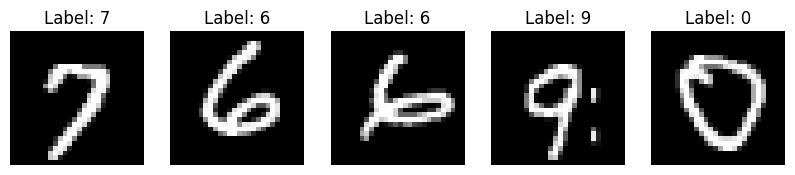

In [26]:
# Select first 2 images

n_images = 5

# Plot
plt.figure(figsize=(2*n_images,2))

for i in range(n_images):
    img1 = X_test[i].reshape(28,28)
    
    
    plt.subplot(1,n_images,i+1)
    plt.imshow(img1, cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')

plt.show()

## Bhattacharyya Distance

The Bhattacharyya coefficient measures overlap:
$$BC(p,q) = \int \sqrt{p(x) q(x)} \, dx,$$
and the distance is:
$$D_B(p,q) = -\ln(BC(p,q)),$$
or in closed form:
$$
D_B(P,Q)=\frac{1}{4}\ln{\left(\frac{1}{4}\left(\frac{\sigma^2_p}{\sigma^2_q}+\frac{\sigma^2_q}{\sigma^2_p}+2\right)\right)}
+
\frac{1}{4}\left(\frac{\left(\mu_p-\mu_q\right)^2}{\sigma^2_p+\sigma^2_q}\right)
$$
where we assume that $P_{ij}\sim\mathcal{N}(\mu_{p},\sigma_{p})$ and $Q\sim\mathcal{N}(\mu_{q},\sigma_{q})$, i.e. they are samples from normal distributions with expected value $\mu$ and standard deviation $\sigma$.

In [9]:
@interact(
    p_mu=widgets.FloatSlider(min=-3, max=3, step=0.1, value=0),
    p_std=widgets.FloatSlider(min=0, max=3, step=0.1, value=1),
    q_mu=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1),
    q_std=widgets.FloatSlider(min=0, max=3, step=0.1, value=1),
)
def plot_bc(p_mu=0, p_std=1, q_mu=1, q_std=1):
    p_pdf, q_pdf, x = generate_dummy_points(p_mu, p_std, q_mu, q_std)
    plt.plot(x, p_pdf, label="p ~ N(0,1)", lw=2)
    plt.plot(x, q_pdf, label="q ~ N(1,1)", lw=2)
    plt.fill_between(x, np.minimum(p_pdf, q_pdf), alpha=0.3, color="gray", label="Overlap")
    
    plt.plot(x, np.sqrt(p_pdf * q_pdf), color="purple", lw=2, label="√(p(x)q(x))")
    plt.fill_between(x, np.sqrt(p_pdf * q_pdf), alpha=0.3, color="purple")
    plt.title("Bhattacharyya Coefficient Visualization")
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='p_mu', max=3.0, min=-3.0), FloatSlider(value=1.0, de…

## Hellinger Distance

$$D_H(p,q) = \sqrt{1 - BC(p,q)},$$

or in closed form:

$$
D_H(p,q) = \sqrt{1-\sqrt{\frac{2{\sigma}_{p}{\sigma}_{q}}{{\sigma}_{p}^2 + {\sigma}_{q}^2}}
e^{-\frac{1}{4}\cdot\frac{(\mu_{p}-\mu_{q})^2}{{\sigma}_{p}^2 + {\sigma}_{q}^2}}},
$$
where we assume that $P_{ij}\sim\mathcal{N}(\mu_{p},\sigma_{p})$ and $Q\sim\mathcal{N}(\mu_{q},\sigma_{q})$, i.e. they are samples from normal distributions with expected value $\mu$ and standard deviation $\sigma$.

## Kullback-Leibler Divergence

Measures the information loss when $q$ is used to approximate $p$.

$$D_{KL}(p||q) = \int p(x) \, \log \frac{p(x)}{q(x)} \, dx$$

In [10]:
@interact(
    p_mu=widgets.FloatSlider(min=-3, max=3, step=0.1, value=0),
    p_std=widgets.FloatSlider(min=0, max=3, step=0.1, value=1),
    q_mu=widgets.FloatSlider(min=-3, max=3, step=0.1, value=1),
    q_std=widgets.FloatSlider(min=0, max=3, step=0.1, value=1),
)
def plot_kl(p_mu=0, p_std=1, q_mu=1, q_std=1):
    p_pdf, q_pdf, x = generate_dummy_points(p_mu, p_std, q_mu, q_std)
    plt.plot(x, p_pdf, label="p ~ N(0,1)", lw=2)
    plt.plot(x, q_pdf, label="q ~ N(1,1)", lw=2)
    
    kl_integrand = p_pdf * np.log(p_pdf / q_pdf)
    plt.plot(x, kl_integrand, color="red", lw=2, label="KL(p||q)")
    plt.fill_between(x, kl_integrand, alpha=0.3, color="purple")
    plt.axhline(0, color="black", lw=1)
    plt.title("KL Divergence Integrand")
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='p_mu', max=3.0, min=-3.0), FloatSlider(value=1.0, de…